<a href="https://colab.research.google.com/github/liuxx479/Outlier/blob/master/notebooks/ResNet_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function, division, absolute_import

import numpy.random as npr
import os

import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
import jax.numpy as np
from jax.config import config
from jax import jit, grad, random
from jax.experimental import optimizers
from jax.experimental import stax
import tensorflow as tf
from jax.experimental.stax import (AvgPool, BatchNorm, Conv, Dense, FanInSum,
                                   FanOut, Flatten, GeneralConv, Identity,
                                   MaxPool, Relu, LogSoftmax)

########### JL note: mostly following https://colab.research.google.com/github/google/jax/blob/master/docs/notebooks/neural_network_with_tfds_data.ipynb
########### https://github.com/google/jax/blob/master/examples/resnet50.py

In [82]:
!pip install --quiet git+https://github.com/liuxx479/Outlier.git

%tensorflow_version 2.x
%pylab inline
import tensorflow_datasets as tfds
from outlier.datasets import gaussian_convergence

######### mount google drive file
from google.colab import drive
drive.mount('/content/drive')

root = '/content/drive/My Drive'
data_path = os.path.join(root,'tensorflow_datasets/')
model_path= os.path.join(root,'models/')

if not os.path.isdir(model_path):
    os.makedirs(model_path)

Populating the interactive namespace from numpy and matplotlib
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random', 'info']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [0]:
########## load data from gdrive, if need to downlaod again, set download=1
VERSION = tfds.core.Version('0.1.0')
dataset, info = tfds.load(name="gaussian_convergence", download=0, split="train", data_dir=data_path, with_info=True)

In [139]:
print ('data size:',info.splits['train'].num_examples)

data size 20000


tf.Tensor([0.16992588 0.7251126 ], shape=(2,), dtype=float32)


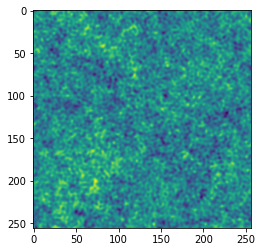

In [10]:
for example in dataset.take(1):  #split the whole set into N mini-batches
  kappa_map, params = example["map"], example["params"]
  imshow(kappa_map)
  print(params)

In [0]:
S8_gen= lambda params: np.sqrt(params.T[0]/0.3)*params.T[1]

In [0]:
############ JL: resnet architecture, mostly unchanged, other than removed bunch of idensity matrices

def ConvBlock(kernel_size, filters, strides=(2, 2)):
  ks = kernel_size
  filters1, filters2, filters3 = filters
  Main = stax.serial(
      Conv(filters1, (1, 1), strides), BatchNorm(), Relu,
      Conv(filters2, (ks, ks), padding='SAME'), BatchNorm(), Relu,
      Conv(filters3, (1, 1)), BatchNorm())
  Shortcut = stax.serial(Conv(filters3, (1, 1), strides), BatchNorm())
  return stax.serial(FanOut(2), stax.parallel(Main, Shortcut), FanInSum, Relu)

def IdentityBlock(kernel_size, filters):
  ks = kernel_size
  filters1, filters2 = filters
  def make_main(input_shape):
    # the number of output channels depends on the number of input channels
    return stax.serial(
        Conv(filters1, (1, 1)), BatchNorm(), Relu,
        Conv(filters2, (ks, ks), padding='SAME'), BatchNorm(), Relu,
        Conv(input_shape[3], (1, 1)), BatchNorm())
  Main = stax.shape_dependent(make_main)
  return stax.serial(FanOut(2), stax.parallel(Main, Identity), FanInSum, Relu)

# ResNet architectures compose layers and ResNet blocks
def ResNet50(num_classes):
  ########## JL to do: maybe remove some IdentityBlocks..
  return stax.serial(
      GeneralConv(('HWCN', 'OIHW', 'NHWC'), 64, (7, 7), (2, 2), 'SAME'),
      BatchNorm(), 
      Relu, 
      MaxPool((3, 3), strides=(2, 2)),
      ConvBlock(3, [64, 64, 256], strides=(1, 1)),
      IdentityBlock(3, [64, 64]),
      IdentityBlock(3, [64, 64]),
      # ConvBlock(3, [128, 128, 512]),
      # IdentityBlock(3, [128, 128]),
      # IdentityBlock(3, [128, 128]),
      # IdentityBlock(3, [128, 128]),
      ConvBlock(3, [256, 256, 1024]),
      IdentityBlock(3, [256, 256]),
      # IdentityBlock(3, [256, 256]),
      # IdentityBlock(3, [256, 256]),
      # IdentityBlock(3, [256, 256]),
      # IdentityBlock(3, [256, 256]),
      ConvBlock(3, [512, 512, 2048]),
      # IdentityBlock(3, [512, 512]),
      IdentityBlock(3, [512, 512]),
      AvgPool((7, 7)), 
      Flatten, 
      Dense(num_classes))

In [0]:
from jax import random
rng_key = random.PRNGKey(0)

In [0]:
def loss(params, batch):
  kappa_map, params_true = batch
  params_pred = predict_fun(params, kappa_map)
  #out1 = np.sum((S8_gen(params_pred) - S8_gen(params_true))**2) ## controls S8
  out2 = np.sum((params_pred - params_true)**2) ## controls individual params
  return out2

In [0]:
############ JL: batch generator
dataset.shuffle(1000)
dataset=dataset.repeat()

def synth_batches():
  for ibatch in dataset.batch(batch_size):
    yield tf.transpose(tf.expand_dims(ibatch['map'],-1), (1,2,3,0)).numpy(), ibatch['params'].numpy()

batches = synth_batches()
test_batch = next(batches)
kappa_map, params_input = test_batch

In [0]:
############# JL: training
batch_size = 32 ### number of maps per batch

num_classes = 2
input_shape = (256, 256, 1, batch_size)
# num_steps = 100

init_fun, predict_fun = ResNet50(num_classes)
_, init_params = init_fun(rng_key, input_shape)
# init_params = np.load(model_path+'resnet_params_{:.0f}epochs_{:.2f}stepsize.npy'.format(5000, 0.05))

step_size = 0.05
opt_init, opt_update, get_params = optimizers.adam(step_size) ##### seems to work
# opt_init, opt_update, get_params = optimizers.adagrad(step_size) #### seems to work
# opt_init, opt_update, get_params = optimizers.sgd(step_size) ### doesn't work
# opt_init, opt_update, get_params = optimizers.nesterov(step_size, mass=0.9) ### doesn't work
# opt_init, opt_update, get_params = optimizers.momentum(step_size, mass=0.9) ## doesn't work

@jit
def update(i, opt_state, batch):
  params = get_params(opt_state)
  return opt_update(i, grad(loss)(params, batch), opt_state)

opt_state = opt_init(init_params)

num_steps = 10000
for epoch in range(num_steps):
  start_time = time.time()
  
  this_batch=next(batches)
  opt_state = update(i, opt_state, this_batch)

  if not epoch%10: ## print out every 10 epochs
    epoch_time = time.time() - start_time
    test_NNparams = get_params(opt_state)
    train_loss = loss(test_NNparams, this_batch)
    test_loss = loss(test_NNparams, test_batch)
    print("Epoch {} in {:0.2f}s, train loss: {:0.2f}, test loss: {:0.2f}".format(epoch, epoch_time, train_loss, test_loss))


Epoch 0 in 15.43s, train loss: 6547349504.00, test loss: 4723446784.00
Epoch 10 in 0.22s, train loss: 442392.16, test loss: 1829226.88
Epoch 20 in 0.22s, train loss: 793479.00, test loss: 717517.38
Epoch 30 in 0.23s, train loss: 165246.89, test loss: 227693.62
Epoch 40 in 0.23s, train loss: 24097.57, test loss: 10359.96
Epoch 50 in 0.22s, train loss: 72228.84, test loss: 30919.88
Epoch 60 in 0.22s, train loss: 5505.43, test loss: 7750.44
Epoch 70 in 0.23s, train loss: 7170.66, test loss: 7547.84
Epoch 80 in 0.22s, train loss: 16910.59, test loss: 7011.22
Epoch 90 in 0.23s, train loss: 635.33, test loss: 7555.25
Epoch 100 in 0.22s, train loss: 7829.35, test loss: 6412.01
Epoch 110 in 0.23s, train loss: 7877.99, test loss: 6657.91
Epoch 120 in 0.22s, train loss: 2388.19, test loss: 6158.79
Epoch 130 in 0.22s, train loss: 11134.80, test loss: 6062.90
Epoch 140 in 0.22s, train loss: 6533.40, test loss: 6062.59
Epoch 150 in 0.22s, train loss: 7144.75, test loss: 6816.79
Epoch 160 in 0.22s, 

In [0]:
########## test file save -- pass ############
## saved as npy, and can be loaded and use as model prediction directly
# np.save(model_path+'test', test_params)
# test_model = np.load(model_path+'test.npy',allow_pickle=1)
# loss(test_model, this_batch)

In [0]:
########### test generator output shape - pass
final_NNparams = get_params(opt_state)
np.save(model_path+'resnet_params_{:.0f}epochs_{:.2f}stepsize.npy'.format(epoch+1, step_size), final_NNparams)

predictions = predict_fun(final_NNparams, kappa_map)

In [0]:
true_s8=S8_gen(params_input)
pred_s8=S8_gen(predictions)

figure(figsize=(14,4))
subplot(1,3,1)
scatter(params_input.T[0], params_input.T[1],color='r')
title('input parameters')
xlabel('om')
ylabel('sigma8')
subplot(1,3,2)
scatter(predictions.T[0], predictions.T[1],color='b')
title('output parameters')
xlabel('om')
ylabel('sigma8')
subplot(1,3,3)
scatter(true_s8, pred_s8, color='k')
xlabel('input S8')
ylabel('predicted S8')
# ylim(0,1)
plt.tight_layout()

In [0]:
############ check  parameter shape
j=0
for iparam in trained_params:
  print ('layer:',j, '/ parameter shape:', array(iparam).shape)
  #print (iparam)
  j+=1